In [17]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [19]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [20]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna('NA')

In [21]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = df[numerical_cols].fillna(0.0)

In [22]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

assert len(df) == (len(df_train) + len(df_val) + len(df_test))

In [24]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [25]:
y_train = df_train['converted'].values
y_val = -df_val['converted'].values

numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
scores = {}

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores[col] = auc

best_feature = max(scores, key=scores.get)
print("Best AUC feature:", best_feature)

Best AUC feature: number_of_courses_viewed


In [26]:
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical_columns =['lead_source', 'industry', 'employment_status','location']

dv = DictVectorizer(sparse=False)
train_dicts = df_train[numerical_columns + categorical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train['converted'].values

val_dicts = df_val[numerical_columns + categorical_columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['converted'].values
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_val_pred)
print('Validation AUC:', round(auc, 3))

Validation AUC: 0.817


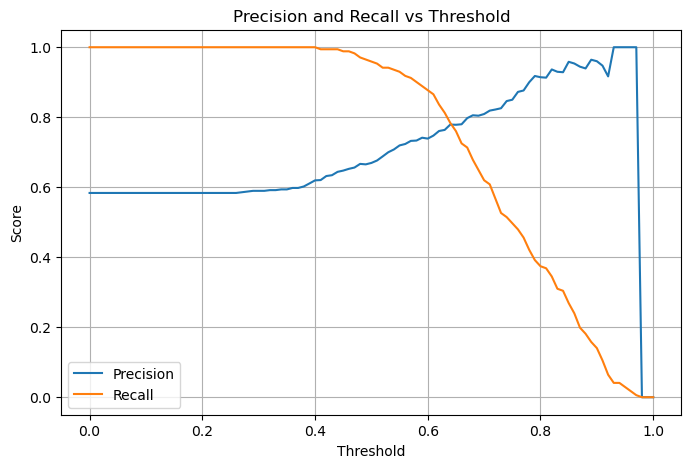

In [27]:
thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []
for t in thresholds:
    y_pred = (y_val_pred >= t).astype(int)
    if y_pred.sum() == 0:
        prec = 0.0
    else:
        prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    precisions.append(prec)
    recalls.append(rec)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
diffs = np.abs(np.array(precisions) - np.array(recalls))
idx_min = np.argmin(diffs)
threshold_intersect = thresholds[idx_min]
print("\nQuestion 3 result: precision-recall intersection threshold (closest) = {:.3f}".format(threshold_intersect))


Question 3 result: precision-recall intersection threshold (closest) = 0.980


In [29]:
intersection = np.argwhere(np.isclose(precisions, recalls, atol=0.01)).flatten()
if intersection.size > 0:
    threshold_at_intersection = thresholds[intersection[0]]
    print("Intersection at threshold:", round(threshold_at_intersection, 3))
else:
    print("No intersection found.")

Intersection at threshold: 0.64


In [30]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for i, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    train_df = df_full_train.iloc[train_idx].reset_index(drop=True)
    val_df = df_full_train.iloc[val_idx].reset_index(drop=True)

    dv = DictVectorizer(sparse=False)

    X_train = dv.fit_transform(train_df[numerical_columns + categorical_columns].to_dict(orient='records'))
    X_val = dv.transform(val_df[numerical_columns + categorical_columns].to_dict(orient='records'))
    
    y_train = train_df['converted'].values
    y_val = val_df['converted'].values

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_val_pred = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_val_pred)
    scores.append(auc)

    print(f'Fold {i+1}: AUC = {auc:.6f}')

scores = np.array(scores)
print('AUCs per fold:', np.round(scores, 6))
print('Mean AUC:', round(scores.mean(), 6))
print('Std AUC:', round(scores.std(), 6))

NameError: name 'KFold' is not defined